In [111]:
%%javascript

# Bind cmd-shift-d to duplicate line of code
Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('cmd-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

__Universal Robot Control__

In [2]:
import urx
import time, pickle
import numpy as np
import math3d as m3d

In [3]:
robot = urx.Robot("10.42.0.162", use_rt=True)

tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 69
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1093
tried 11 times to find a packet in data, advertised packet size: -2, type: 3
Data length: 1418


In [112]:
robot.set_digital_out(0, 1)
time.sleep(1)
robot.set_digital_out(0, 0)

In [5]:
robot.set_tcp((0, 0, 0.05, 0, 0, 0)) #ckeck Installation tab

In [63]:
robot.translate((0, 0.05, 0.), acc=0.05, vel=0.05) #acceleration, velocity

<Transform:
<Orientation: 
array([[ -9.14753315e-01,  -4.03899609e-01,  -9.56447788e-03],
       [ -4.03925174e-01,   9.14791655e-01,   8.25939251e-04],
       [  8.41590801e-03,   4.61886406e-03,  -9.99953918e-01]])>
<Vector: (0.46967, 0.11835, 0.24578)>
>

In [7]:
robot.translate_tool((0, 0, -0.03), acc=0.05, vel=0.05)

Robot not running: {'isPowerOnRobot': True, 'controlMode': 0, 'isRobotConnected': True, 'speedScaling': 0.2885651412344339, 'isSecurityStopped': True, 'timestamp': 88657896000, 'isProgramPaused': False, 'isEmergencyStopped': False, 'speedFraction': 1.0, 'isProgramRunning': True, 'type': 0, 'size': 46, 'robotMode': 7, 'isRealRobotEnabled': True}


RobotException: Robot stopped

Robot not running: {'isPowerOnRobot': True, 'controlMode': 0, 'isRobotConnected': True, 'speedScaling': 1.0, 'isSecurityStopped': False, 'timestamp': 88705112000, 'isProgramPaused': False, 'isEmergencyStopped': False, 'speedFraction': 1.0, 'isProgramRunning': False, 'type': 0, 'size': 46, 'robotMode': 7, 'isRealRobotEnabled': False}


In [ ]:
robot.get_pose()

In [ ]:
robot.get_pos()

In [ ]:
robot.getl()

In [8]:
def save_current_pos(fname):
    p = robot.getl()
    np.savetxt(fname, np.array(p))
       

def move_to_pos(fname, *args, **kwargs):
    p = np.loadtxt(fname)
    robot.movel(p, *args, **kwargs)
    
def print_pos(fname):
    p = np.loadtxt(fname)
    print(p)
    

In [9]:
save_current_pos('start')

In [42]:
def move_x_y(x, y):
    p = np.array(robot.getl())
    p[0] = x
    p[1] = y
    robot.movel(p, vel=0.05, acc=0.05)

In [ ]:
move_to_pos("in", vel=0.05, acc=0.05)

In [ ]:
robot.getl()

In [ ]:
robot.x += 0.01 #1 hour 10 minutes up to this point

In [ ]:
p = robot.get_pos()

In [ ]:
p.array

In [ ]:
m3d.Vector(p.array)

In [113]:
import threading
from IPython.display import display
import ipywidgets as widgets
import time

fw = widgets.HTML(
    value='',
    placeholder='No data',
    description='Force:',
)

def observe_force(fw):
    while True:
        fw.value = "<br>".join(["{0:5} {1:7.3f}".format(*c) for c in 
                                zip("x y z rx ry rz".split(), robot.get_tcp_force())])

thread = threading.Thread(target=observe_force, args=(fw,))
display(fw)
thread.start()



In [114]:
robot.get_tcp_force().__str__()

'[-5.50243915 -6.9897237  -5.2953105   0.41093459 -0.68804832  0.75343419]'

__Here starts CV__

In [10]:
%matplotlib notebook

import cv2 #pip install opencv-python
import matplotlib.pyplot as plt
import signal, time
import numpy as np
from numpy import linalg
#to check: cv2.getBuildInformation()
print (*filter(lambda s: "FFMPEG" in s, cv2.getBuildInformation().split("\n")))

#To install opencv with ffmpeg in conda
#https://github.com/conda-forge/opencv-feedstock/
#pip uninstall opencv
#pip uninstall opencv-python
#conda unistall opencv
#conda install conda=4.0.11
#conda config --add channels conda-forge
#conda install opencv


    FFMPEG:                      YES


In [11]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [115]:
%%bash
ls /dev | grep video

video0
video2


In [13]:
vc = cv2.VideoCapture(2) #0 for the first webcam, 1 for the second..

In [14]:
def imshow(frame, from_color_space='bgr'):
    plt.figure()
    if from_color_space == 'bgr':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    elif from_color_space == 'hsv':
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_HSV2RGB)    # makes the blues image look real colored
    else:
        rgb_frame=frame
    webcam_preview = plt.imshow(rgb_frame)

def online_view():
    plt.ion()

    if vc.isOpened(): # try to get the first frame
        is_capturing, frame = vc.read()
        imshow(frame)   
    else:
        is_capturing = False

    signal.signal(signal.SIGINT, signal_handler)
    is_interrupted = False
    while is_capturing:
        is_capturing, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
        webcam_preview.set_data(frame)
        plt.draw()

        try:    # Avoids a NotImplementedError caused by `plt.pause`
            plt.pause(0.05)
        except Exception:
            pass
        if is_interrupted:
            vc.release()
            break
    
def get_frame():
    timeout = time.time() + 0.1
    while time.time() < timeout:
        if vc.isOpened(): # try to get the first frame
            is_capturing, frame = vc.read()
        else:
            raise (Exception("Unable to capture"))
    return frame


#frame = get_frame()
#imshow(frame)

#online_view()

In [117]:
imshow(get_frame())
online_view()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: name 'webcam_preview' is not defined

In [ ]:
frame = get_frame()
imshow(frame)

__The blob detection__

In [65]:
move_to_pos('start', acc=0.05, vel=0.05)

In [122]:
def color_take(greenMin, greenMax, blur=40):
    # Read image
    # im = cv2.imread("detection/cubes_4.png")
    im = get_frame()
    cv2.imwrite('test.png', im)

    imshow(im)

    # Blur image to remove noise
    im = cv2.GaussianBlur(im, (5,5), blur)

    imshow(im)

    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

    #greenMin = (30, 90, 120) #./range-detector.py -i test.png -f HSV
    #greenMax = (150, 255, 255)

    # Sets pixels to white if in purple range, else will be set to black
    mask = cv2.inRange(hsv, greenMin, greenMax)

    # Bitwise-AND of mask and purple only image - only used for display
    masked = cv2.bitwise_and(im, im, mask= mask)

    imshow(masked)

    # dilate makes the in range areas larger
    mask = cv2.erode(mask, None, iterations=5)

    # mask = cv2.dilate(mask, None, iterations=8)


    # Bitwise-AND of mask and purple only image - only used for display
    masked = cv2.bitwise_and(im, im, mask= mask)

    imshow(masked)
    pts = []

    # find contours in the mask and initialize the current
    # (x, y) center of the ball
    cnts = cv2.findContours(mask.copy(), cv2.RETR_LIST,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    center = None

    print (len(cnts))

    # only proceed if at least one contour was found
    for c in cnts:
        # find the largest contour in the mask, then use
        # it to compute the minimum enclosing circle and
        # centroid
    #     c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)

        # only proceed if the radius meets a minimum size
        if radius > 25 and radius < 200:
            print (radius)

            M = cv2.moments(c)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            if center[1] > 400:
                continue
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
            cv2.circle(im, (int(x), int(y)), int(radius),
                (0, 255, 255), 2)
            cv2.circle(im, center, 5, (0, 0, 255), -1)

            # update the points queue
            pts.append(center)

    imshow(im)
    return pts

In [ ]:
gMin = (30, 75, 186) #./range-detector.py -i test.png -f HSV
gMax = (88, 255, 255)
im = color_take(gMin,gMax)

<IPython.core.display.Javascript object>


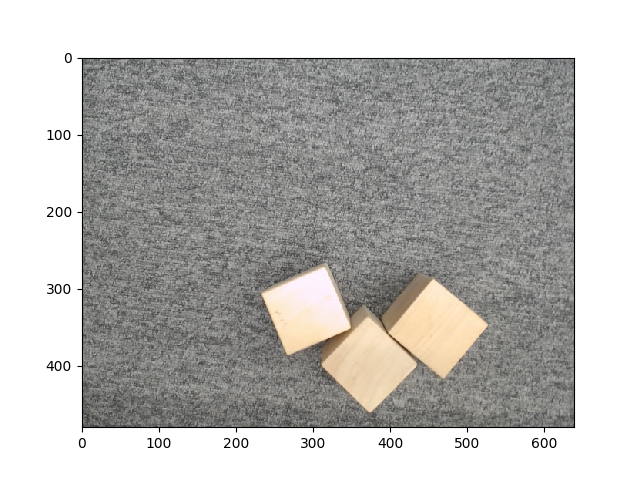

<IPython.core.display.Javascript object>


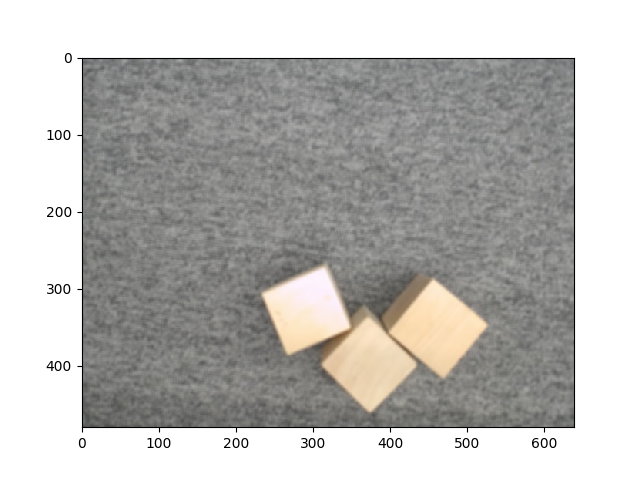

<IPython.core.display.Javascript object>


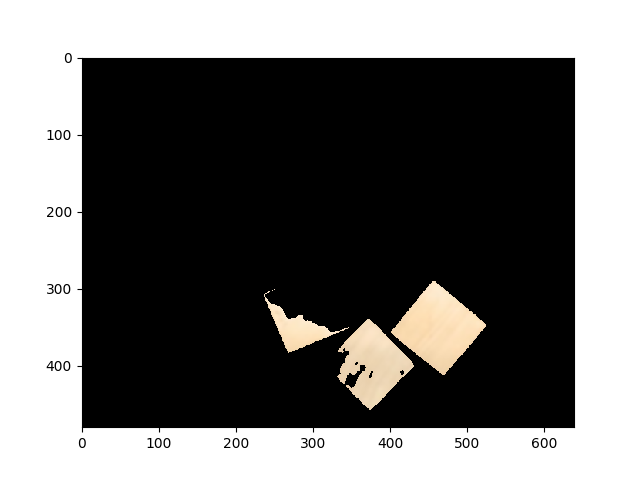

<IPython.core.display.Javascript object>


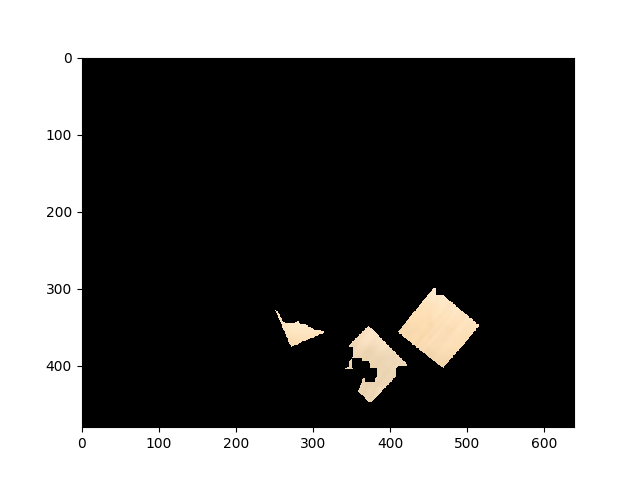

3
49.02546691894531
34.22373580932617
52.652259826660156


<IPython.core.display.Javascript object>


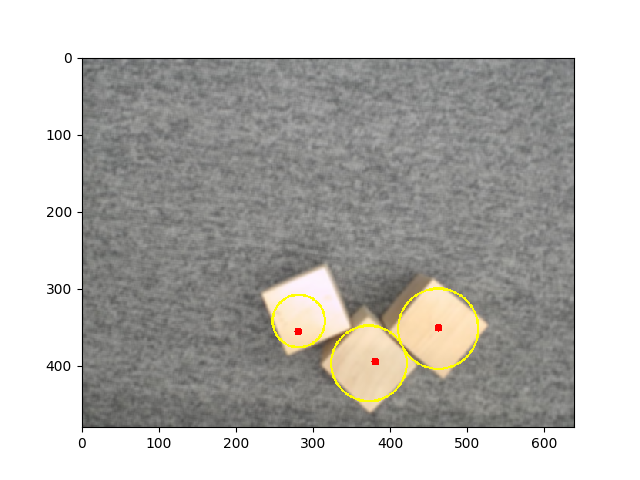

[(380, 395), (280, 356), (462, 351)]

In [123]:
pink_take()

In [ ]:
pts

In [108]:
save_current_pos('green')

In [ ]:
move_to_pos('in', acc=0.05, vel=0.05)

In [96]:
save_current_pos('pink')

In [105]:
def green_take():
    gMin = (30, 75, 186) #./range-detector.py -i test.png -f HSV
    gMax = (88, 255, 255)
    return color_take(gMin,gMax)

def pink_take():
    pinkMin = (11, 45, 233) #./range-detector.py -i test.png -f HSV
    pinkMax = (176, 93, 255)
    return color_take(pinkMin, pinkMax, 10)

def x_take(pts,num):
    return pts[num][0]
    
def y_take(pts,num):
    return pts[num][1]

def determine_kef():
    im = green_take()

    x_f = x_take(im,0)
    y_f = y_take(im,0)

    x_s = x_take(im,1)
    y_s = y_take(im,1)

    pic_d = ((x_f-x_s)**2 + (y_f-y_s)**2)**(1/2)
    kef = 0.055/pic_d
    
    return kef

def angle_sin():
    move_to_pos("start", vel=0.05, acc=0.05)
    im1 = green_take()
    x1 = x_take(im1,0)
    y1 = y_take(im1,0)
    
    robot.translate((0.05, 0, 0.), acc=0.05, vel=0.05) #acceleration, velocity
    
    im2 = green_take()
    x2 = x_take(im2,0)
    y2 = y_take(im2,0)
    
    d_ch = ((x1-x2)**2 + (y1-y2)**2)**(1/2)
    return (y1-y2)/(d_ch)

def get_real_coords(point):
    y = -point[0]*kef + y0
    x = -point[1]*kef + x0
    return x, y

def check_targ():
    move_to_pos("start", vel=0.05, acc=0.05)
    imag = green_take()
    
    x, y = get_real_coords(imag[0])
    
    p = np.array(robot.getl())
    p[0] = x
    p[1] = y
    p[2] = 0.015
    robot.movel(p, vel=0.05, acc=0.05)
    p[2] = -0.04
    robot.movel(p, vel=0.05, acc=0.05)
    p[2] = 0.05
    robot.movel(p, vel=0.05, acc=0.05)
    robot.set_digital_out(0, 1)
    time.sleep(1)

    
    return x, y

def sort():
    while True:
        move_to_pos("start", vel=0.15, acc=0.05)
        green = green_take()
        pink = pink_take()
        if len(green) == 0 and len(pink) == 0:
            time.sleep(10)
            continue
            
        take_green = len(green)

        box = green[0] if take_green else pink[0]
        x, y = get_real_coords(box)

        p = np.array(robot.getl())
        p[0] = x
        p[1] = y
        p[2] = 0.015
        robot.movel(p, vel=0.5, acc=0.2)
        p[2] = -0.04
        robot.movel(p, vel=0.05, acc=0.2)
        robot.set_digital_out(0, 1)
        p[2] = 0.15
        robot.movel(p, vel=0.2, acc=0.1)
        if take_green:
            move_to_pos("green", vel=0.5, acc=0.2)
        else:
            move_to_pos("pink", vel=0.5, acc=0.2)
        robot.set_digital_out(0, 0)
        
   
    
    

2
51.27696228027344
53.444000244140625


<IPython.core.display.Javascript object>


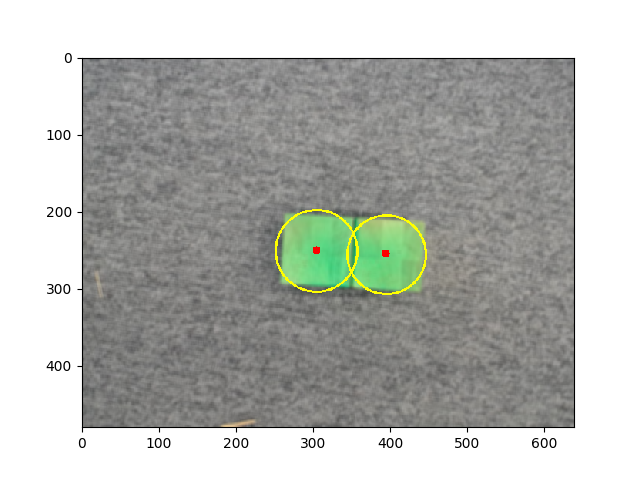

0.0006105084372849053

In [60]:
kef = determine_kef()
kef

1
53.10847854614258


<IPython.core.display.Javascript object>


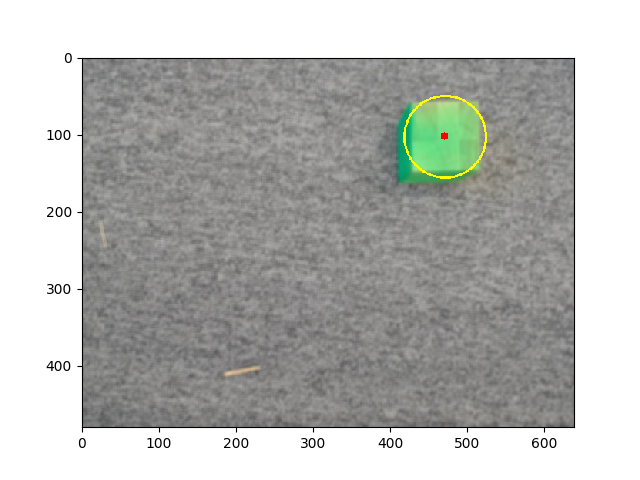

1
53.07551574707031


<IPython.core.display.Javascript object>


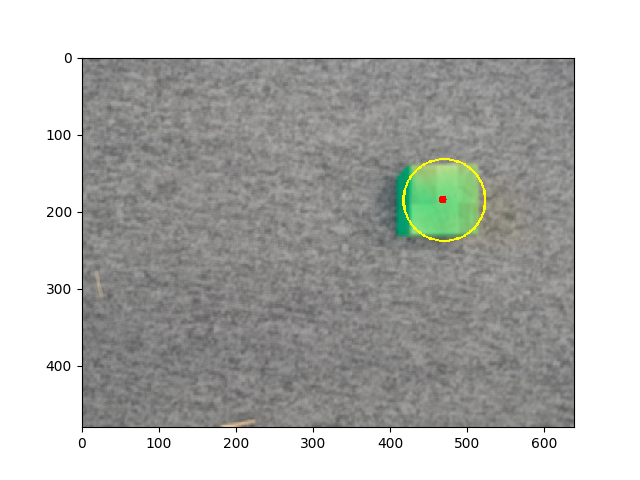

-0.9997026906430501

In [62]:
angle = angle_sin()
angle

1
54.10416030883789


<IPython.core.display.Javascript object>


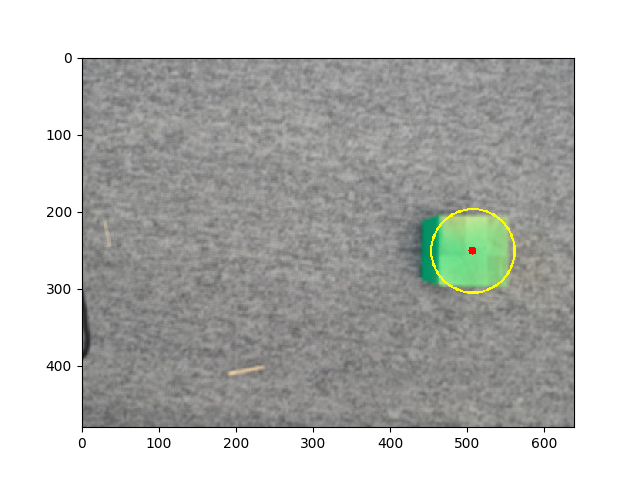

(0.46231660165307431, -0.03710022669609242)

In [86]:
check_targ()

1
54.23339080810547


<IPython.core.display.Javascript object>


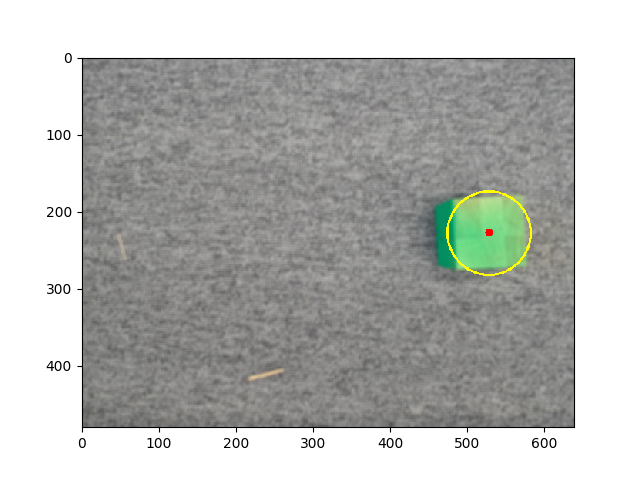

[(528, 227)]

In [66]:
green_take()

In [84]:
robot.getl()

[0.46752056151714155,
 -0.04999303518856851,
 -0.043539236773554243,
 0.6037890695307228,
 -2.9991387973711214,
 -0.06955935631121152]

In [74]:
x0 = robot.get_pos()[0] + 227*kef
y0 = robot.get_pos()[1] + 528*kef
x0, y0

(0.6155542194115855, 0.27181704257006967)

In [110]:
sort()

2
52.500099182128906
51.41264724731445
1
40.463008880615234
1
53.85701370239258
1
50.152366638183594
1
53.85701370239258
1
50.152366638183594
0
1
50.152366638183594
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
1
0
1
0
1
0


KeyboardInterrupt: 